# Decision Trees


## Fundamental knowledge

Notice:
- less feature preparation - just numbers and categoricals
- trying random splits of data to evaluate their MAE

In [1]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

In [2]:
import os
import zipfile,kaggle

path = Path('titanic')
kaggle.api.competition_download_cli(str(path))
zipfile.ZipFile(f'{path}.zip').extractall(path)

df = pd.read_csv(path/'train.csv')
tst_df = pd.read_csv(path/'test.csv')
modes = df.mode().iloc[0]

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
def proc_data(df):
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    df['LogFare'] = np.log1p(df['Fare'])
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)

proc_data(df)
proc_data(tst_df)

In [4]:
cats=["Sex","Embarked"]
conts=['Age', 'SibSp', 'Parch', 'LogFare',"Pclass"]
dep="Survived"
indeps=cats+conts

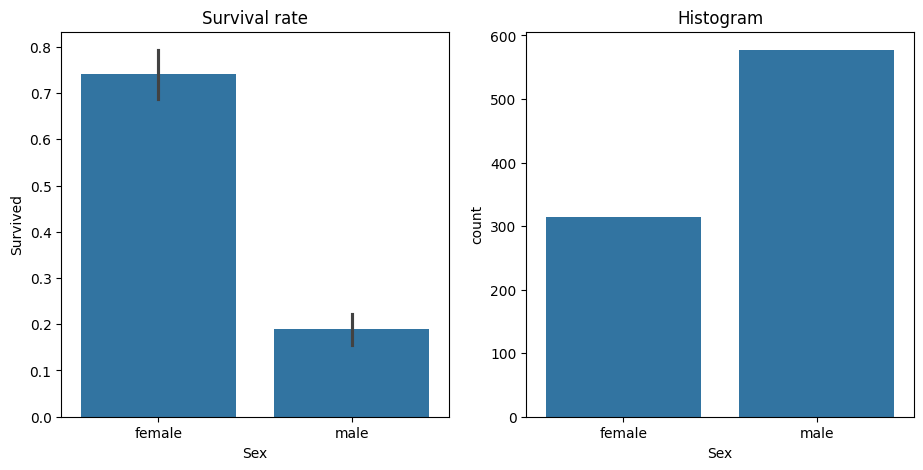

In [5]:
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="Sex", ax=ax1).set(title="Survival rate")
sns.countplot(data=df, x="Sex", ax=ax2).set(title="Histogram");



In [6]:
from numpy import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

random.seed(42)
trn_df, val_df = train_test_split(df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs, trn_y = xs_y(trn_df)
val_xs, val_y = xs_y(val_df)

preds = val_xs.Sex == 0

mean_absolute_error(val_y, preds)

0.21524663677130046

<Axes: xlabel='LogFare', ylabel='Density'>

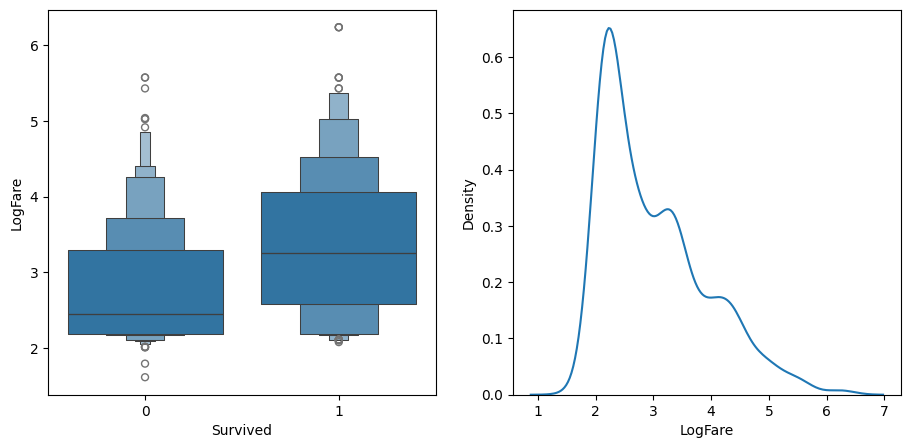

In [7]:
df_fare = trn_df[trn_df.LogFare>0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y="LogFare", ax=axs[0])
sns.kdeplot(data=df_fare, x="LogFare", ax=axs[1])

In [8]:
preds = val_xs.LogFare > 2.7
mean_absolute_error(val_y, preds)

0.336322869955157

## How to split a dataset in 2 on a single dimension?

1. We need to evaluate how good a split is. Split on x={split} divides y's in A,B. If y's are similar within A, and similar within B, that's a good split.
2. We measure similarity of y's in a group, with standard deviation * size of the set
3. We measure split quality by adding score(A)+score(B) and divided by total count
4. Now we just need to take each unique value on a column as candidate split point, calcuate scores, and return the SPLIT with smallest Score
5. Now iterate over all columns

In [9]:
def single_side_score(mask, y):
    total = mask.sum() #count trues
    if total <= 1: return 0
    return y[mask].std() * total

def score_column(col, y, split):
    lhs = col<=split
    rhs = col>split
    return (single_side_score(lhs, y) + single_side_score(rhs, y))/len(y)

score_column(trn_xs.Sex, trn_y, 0.5)

np.float64(0.40787530982063946)

In [10]:
def find_min_score(df, column_name):
    col, y = df[column_name], df[dep]
    unq = col.dropna().unique()
    unq.sort()
    scores = np.array([score_column(col, y, split) for split in unq ])
    idx = scores.argmin()
    return unq[idx], scores[idx]

{ col : find_min_score(trn_df, col) for col in indeps }

{'Sex': (np.int8(0), np.float64(0.40787530982063946)),
 'Embarked': (np.int8(0), np.float64(0.47883342573147836)),
 'Age': (np.float64(6.0), np.float64(0.478316717508991)),
 'SibSp': (np.int64(4), np.float64(0.4783740258817434)),
 'Parch': (np.int64(0), np.float64(0.4805296527841601)),
 'LogFare': (np.float64(2.4390808375825834), np.float64(0.4620823937736597)),
 'Pclass': (np.int64(2), np.float64(0.46048261885806596))}

In [11]:
# above Sex is the lowest score, and the best choice.
# let's take this choice and make next level of the tree

L1 = 'Sex'
if L1 in indeps: indeps.remove(L1)
ismale = trn_df.Sex == 1
males, females = trn_df[ismale], trn_df[~ismale]

{ col : find_min_score(females, col) for col in indeps }


{'Embarked': (np.int8(0), np.float64(0.4295252982857327)),
 'Age': (np.float64(50.0), np.float64(0.4225927658431649)),
 'SibSp': (np.int64(4), np.float64(0.42319212059713535)),
 'Parch': (np.int64(3), np.float64(0.4193314500446158)),
 'LogFare': (np.float64(4.256321678298823), np.float64(0.41350598332911376)),
 'Pclass': (np.int64(2), np.float64(0.3335388911567601))}

## SKLearn

### Trees

In [12]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

In [14]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

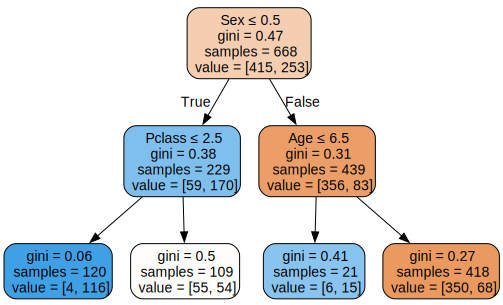

In [15]:
draw_tree(m, trn_xs, size=10)

In [20]:
mean_absolute_error(val_y, m.predict(val_xs))

0.2242152466367713

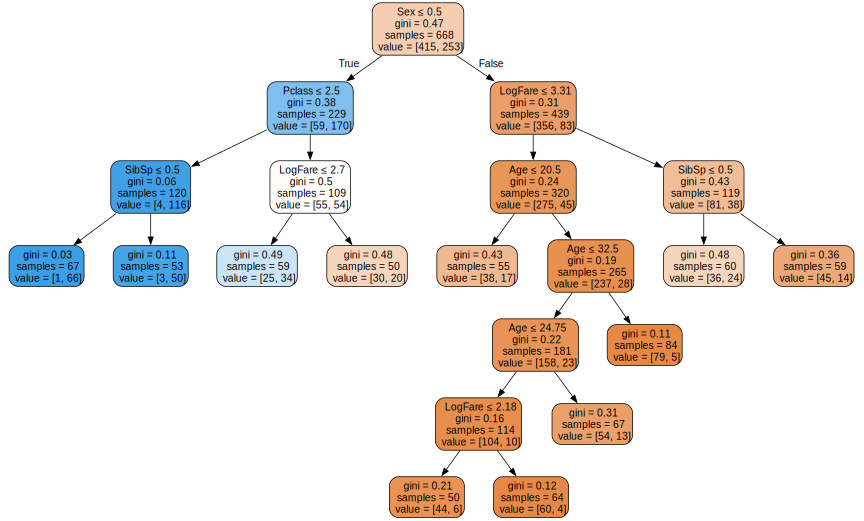

In [18]:
big_tree = DecisionTreeClassifier(min_samples_leaf=50)
big_tree.fit(trn_xs, trn_y)
draw_tree(big_tree, trn_xs, size=12)

In [19]:
mean_absolute_error(val_y, big_tree.predict(val_xs))

0.18385650224215247

In [ ]:
tst_df[cats] = tst_df[cats].apply(lambda x: x.cat.codes)
tst_x, tst_y = xs_y(tst_df)

preds = big_tree.predict(tst_x)
tst_df['Survived'] = preds
tst_df[['PassengerId','Survived']].to_csv('titanic-tree.csv', index=False)

In [31]:
from kaggle import api
from pprint import pprint
#api.competition_submit('titanic-tree.csv', 'Simple Tree', 'titanic')

last_score = api.competition_submissions('titanic')[0].__dict__
pprint(last_score, width=80, indent=2)

{ '_date': datetime.datetime(2025, 10, 1, 12, 35, 10, 530000),
  '_description': 'Simple Tree',
  '_error_description': '',
  '_file_name': 'titanic-tree.csv',
  '_is_frozen': True,
  '_private_score': '',
  '_public_score': '0.76555',
  '_ref': 47129783,
  '_status': <SubmissionStatus.COMPLETE: 1>,
  '_submitted_by': 'marcinzi',
  '_submitted_by_ref': 'marcinzi',
  '_team_name': 'MarcinZi',
  '_total_bytes': 3258,
  '_url': '/submissions/47129783/47129783.raw'}


### Forests

In [33]:
def build_random_tree(prop=0.75):
    n = len(trn_df)
    idxs = random.permutation(n)[:int(n*prop)]    
    tree = DecisionTreeClassifier(min_samples_leaf=5)
    tree.fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])
    return tree

trees = [build_random_tree() for _ in range(100)]
preds = np.stack([t.predict(val_xs) for t in trees]).mean(0).round()
mean_absolute_error(val_y, preds)

0.18385650224215247

In [34]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(trn_xs, trn_y);
mean_absolute_error(val_y, rf.predict(val_xs))

0.18834080717488788

In [35]:
from kaggle import api
from pprint import pprint

preds = rf.predict(tst_x)
tst_df['Survived'] = preds
tst_df[['PassengerId','Survived']].to_csv('titanic-randomforest100.csv', index=False)

api.competition_submit('titanic-tree.csv', 'Random Forest 100', 'titanic')

last_score = api.competition_submissions('titanic')[0].__dict__
pprint(last_score, width=80, indent=2)

100%|██████████| 3.18k/3.18k [00:01<00:00, 3.11kB/s]


{ '_date': datetime.datetime(2025, 10, 1, 12, 50, 4, 477000),
  '_description': 'Random Forest 100',
  '_error_description': '',
  '_file_name': 'titanic-tree.csv',
  '_is_frozen': True,
  '_private_score': '',
  '_public_score': '0.76555',
  '_ref': 47129976,
  '_status': <SubmissionStatus.COMPLETE: 1>,
  '_submitted_by': 'marcinzi',
  '_submitted_by_ref': 'marcinzi',
  '_team_name': 'MarcinZi',
  '_total_bytes': 3258,
  '_url': '/submissions/47129976/47129976.raw'}


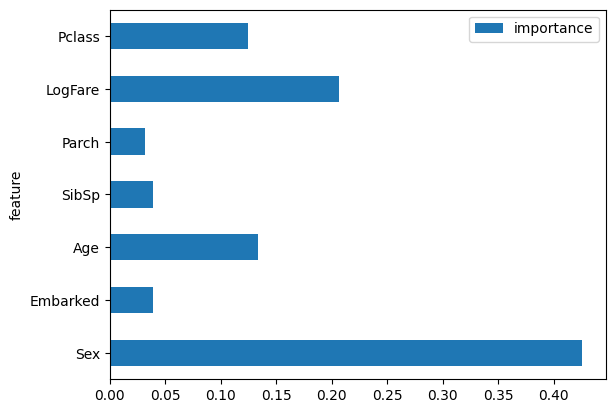

In [55]:
importances = dict(feature=rf.feature_names_in_, importance=rf.feature_importances_)
ax = pd.DataFrame(importances).plot.barh(y='importance', x='feature')